## EDA for H&M dataset

The dataset comprises of 5 segregations, please find the details below:  
1. images: This folder consists of images for most of the articles that are being sold in H&M however all articls don't have respective images.  
2. articles.csv: This csv file consists of metadata for each of the article which are getting sold under H&M banner. It has total 25 columns for each article including metadata information such as product type, product name, product description, etc.  
3. customers.csv: This csv file consists of metadata for each customer id. It has total 7 columns and includes general information regarding a speicific customer such as H&M club member status, age, etc.  
4. transactions_train.csv: This csv file consists of transaction information of any specific article id which any of the customer id has purchased and at what price point the transactions were made and also when was the transaction made.  
5. sample_submission.csv: This csv files consists of customer ids for which the predictions are to be made as to what are the list of article ids that a specific customer id will purchase within a span of one week i.e. 7 days after the training date ends.

In [1]:
# Importing Libraries
import re
import string
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
articles_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

## Exploring Articles Metadata

In [3]:
# List all columns present in article metadata
articles_data.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [4]:
articles_data.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


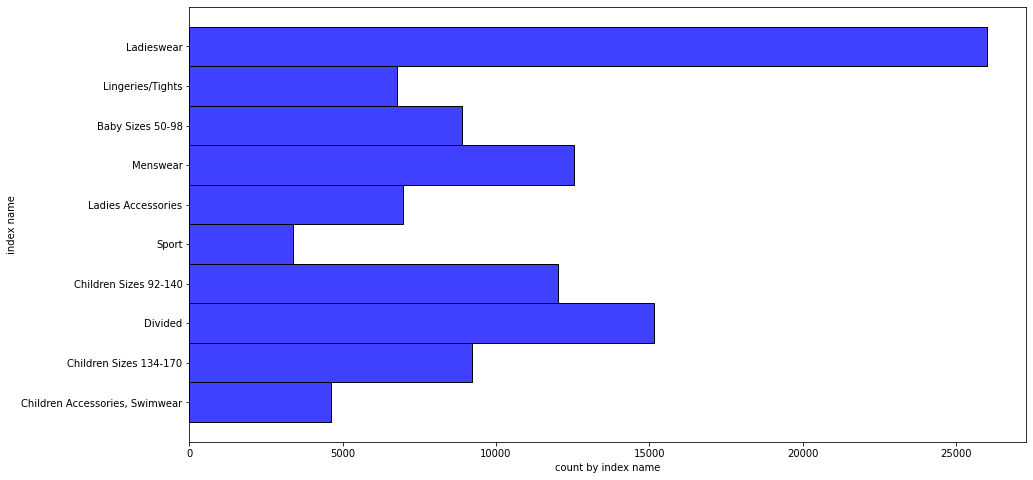

In [5]:
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.histplot(data=articles_data, y='index_name', color='blue')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

From the above horizontal bar graph, its easily visible that out of 10 categories of products, the count of ladieswear articles is the highest in the metadata and is more than 25000 in number followed by Divided, Menswear, etc.

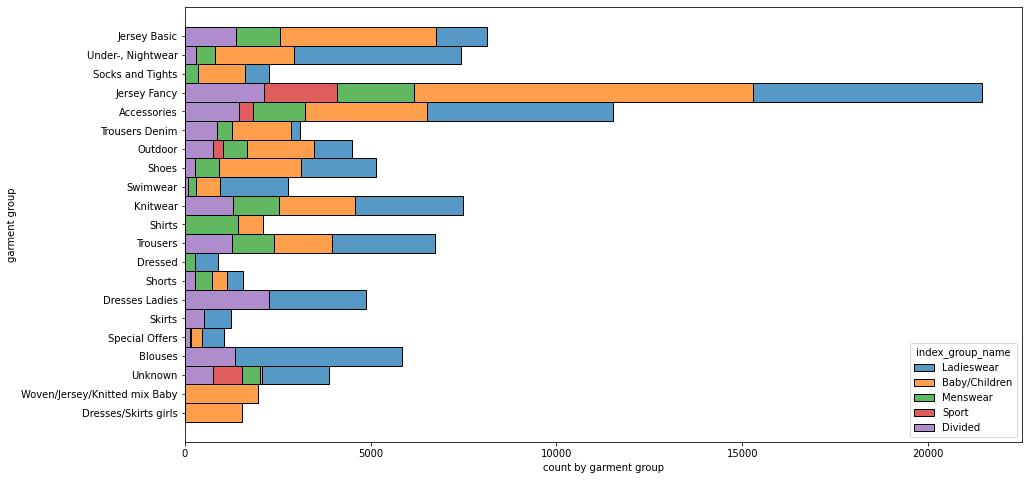

In [6]:
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.histplot(data=articles_data, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

The garments grouped by index: Jersey fancy is the most frequent garment, especially for women and baby/children. The next by number is accessories which is followed by Jersey Basic, Under-nightwear, etc

Lets look up to the combination counts for index group name and index name

In [7]:
articles_data.groupby(['index_group_name', 'index_name']).count()['article_id']

index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
                  Children Sizes 134-170             9214
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                 6961
                  Ladieswear                        26001
                  Lingeries/Tights                   6775
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

Lets look up to the combination counts for product group name and product name

In [8]:
pd.options.display.max_rows = None
articles_data.groupby(['product_group_name', 'product_type_name']).count()['article_id']

product_group_name     product_type_name       
Accessories            Accessories set                 7
                       Alice band                      6
                       Baby Bib                        3
                       Bag                          1280
                       Beanie                         56
                       Belt                          458
                       Bracelet                      180
                       Braces                          3
                       Bucket hat                      7
                       Cap                            13
                       Cap/peaked                    573
                       Dog Wear                       20
                       Earring                      1159
                       Earrings                       11
                       Eyeglasses                      2
                       Felt hat                       10
                       Giftbox          

In [9]:
# Extract number of unique columns values under each column
for col_name in articles_data.columns:
    un_n = articles_data[col_name].nunique()
    print(f'No of unique {col_name}: {un_n}')

No of unique article_id: 105542
No of unique product_code: 47224
No of unique prod_name: 45875
No of unique product_type_no: 132
No of unique product_type_name: 131
No of unique product_group_name: 19
No of unique graphical_appearance_no: 30
No of unique graphical_appearance_name: 30
No of unique colour_group_code: 50
No of unique colour_group_name: 50
No of unique perceived_colour_value_id: 8
No of unique perceived_colour_value_name: 8
No of unique perceived_colour_master_id: 20
No of unique perceived_colour_master_name: 20
No of unique department_no: 299
No of unique department_name: 250
No of unique index_code: 10
No of unique index_name: 10
No of unique index_group_no: 5
No of unique index_group_name: 5
No of unique section_no: 57
No of unique section_name: 56
No of unique garment_group_no: 21
No of unique garment_group_name: 21
No of unique detail_desc: 43404


## Exploring Textual description of articles

### Steps inolved:
#### Preprocessing Steps:
1. Check missing values and remove them
2. Expand Contractions
3. Lowercase the descriptions
4. Remove digits and words containing digits 
5. Remove punctuations

#### EDA for Textual Description:
1. Stopwords Removal  
2. Lemmatization  
3. Creating Document Matrix

In [10]:
articles_desc_data = articles_data[['article_id','detail_desc']]

### Preprocessing Steps

#### 1. Check missing values and remove them


In [11]:
# Counting number of null detailed descriptions for articles
articles_desc_data.isnull().sum()

article_id       0
detail_desc    416
dtype: int64

In [12]:
articles_desc_data.dropna(inplace=True)
articles_desc_data.isnull().sum()

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


article_id     0
detail_desc    0
dtype: int64

In [13]:
articles_desc_data['detail_desc'].unique()

array(['Jersey top with narrow shoulder straps.',
       'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
       'Semi shiny nylon stockings with a wide, reinforced trim at the top. Use with a suspender belt. 20 denier.',
       ...,
       'Short, A-line dress in jersey with a round neckline and V-shaped opening at the front with narrow ties. Long, voluminous raglan sleeves and wide cuffs with covered buttons.',
       'Large plastic hair claw.',
       'Calf-length dress in ribbed jersey made from a cotton blend. Low-cut V-neck at the back, dropped shoulders and long, wide sleeves that taper to the cuffs. Unlined.'],
      dtype=object)

#### 2. Remove Contractions

In [14]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [15]:
# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
articles_desc_data['detail_desc']=articles_desc_data['detail_desc'].apply(lambda x:expand_contractions(x))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The expand_contractions function uses regular expressions to map the contractions in the text to their expanded forms from the dictionary. 

#### 3. Lowercase the decriptions

In [16]:
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc'].apply(lambda x: x.lower())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### 4. Remove digits and words containing digits

In [17]:
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc_cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### 5. Remove punctuations and spaces

In [18]:
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc_cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc_cleaned'].apply(lambda x: re.sub(' +',' ',x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
articles_desc_data['detail_desc_cleaned'].unique()

array(['jersey top with narrow shoulder straps',
       'microfibre tshirt bra with underwired moulded lightly padded cups that shape the bust and provide good support narrow adjustable shoulder straps and a narrow hookandeye fastening at the back without visible seams for greater comfort',
       'semi shiny nylon stockings with a wide reinforced trim at the top use with a suspender belt denier',
       ...,
       'short aline dress in jersey with a round neckline and vshaped opening at the front with narrow ties long voluminous raglan sleeves and wide cuffs with covered buttons',
       'large plastic hair claw',
       'calflength dress in ribbed jersey made from a cotton blend lowcut vneck at the back dropped shoulders and long wide sleeves that taper to the cuffs unlined'],
      dtype=object)

### EDA for Textual Description

#### 
1. Stopwords Removal 
2. Lemmatization

We will use spacy to remove the stopwords and present the lemma form of toekns in article descriptions

In [20]:
# Loading english spacy model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
articles_desc_data['lemmatized'] = articles_desc_data['detail_desc_cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
articles_desc_data.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,article_id,detail_desc,detail_desc_cleaned,lemmatized
0,108775015,Jersey top with narrow shoulder straps.,jersey top with narrow shoulder straps,jersey narrow shoulder strap
1,108775044,Jersey top with narrow shoulder straps.,jersey top with narrow shoulder straps,jersey narrow shoulder strap
2,108775051,Jersey top with narrow shoulder straps.,jersey top with narrow shoulder straps,jersey narrow shoulder strap
3,110065001,"Microfibre T-shirt bra with underwired, moulde...",microfibre tshirt bra with underwired moulded ...,microfibre tshirt bra underwired mould lightly...
4,110065002,"Microfibre T-shirt bra with underwired, moulde...",microfibre tshirt bra with underwired moulded ...,microfibre tshirt bra underwired mould lightly...
5,110065011,"Microfibre T-shirt bra with underwired, moulde...",microfibre tshirt bra with underwired moulded ...,microfibre tshirt bra underwired mould lightly...
6,111565001,"Semi shiny nylon stockings with a wide, reinfo...",semi shiny nylon stockings with a wide reinfor...,semi shiny nylon stocking wide reinforce trim ...
7,111565003,"Semi shiny nylon stockings with a wide, reinfo...",semi shiny nylon stockings with a wide reinfor...,semi shiny nylon stocking wide reinforce trim ...
8,111586001,Tights with built-in support to lift the botto...,tights with builtin support to lift the bottom...,tight builtin support lift black deni light am...
9,111593001,"Semi shiny tights that shape the tummy, thighs...",semi shiny tights that shape the tummy thighs ...,semi shiny tight shape tummy thigh calf encour...
